# SGA-PMX Demo

Skrypt przedstawia przykładową implementację algorytmu Simple Genetic Algorithm (SGA) z operatorem PMX i jego zastosowanie do rozwiązywania problemu komiwojażera (ang. Travelling Salesman Problem, TSP). Popularne instancje problemu TSP można znaleźć w bibliotece TSPLib [1]. Skrypt skupia się na rozwiązywaniu instancji BERLIN52, w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu, a może też i operatorów ewolucyjnych.

Literatura:

[1] TSPLIB, http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from itertools import product

%matplotlib inline

## Input data

In [2]:
def load_data(coords, plot=None):
	n = len(coords) // 2
	coords = np.array(coords).reshape(n, 2)

	A = np.empty((n, n))
	for i, j in product(range(n), range(n)):
		A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())

	if plot:
		plt.figure(figsize=(12,8))
		plt.plot(coords[:, 0], coords[:, 1], 'o')
		for i in range(n):
			plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})
		plt.title(plot)
		plt.show()
	
	return n, A, coords
		

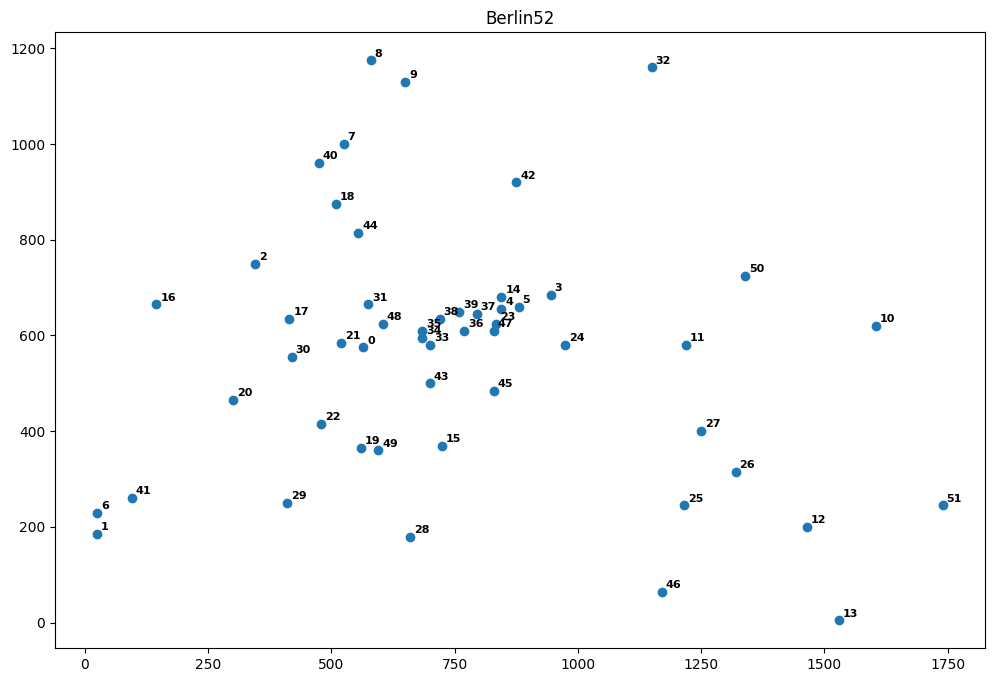

In [3]:
# BERLIN52
n, A, coords = load_data(
    [565.0, 575.0, 25.0, 185.0, 345.0, 750.0, 945.0, 685.0, 845.0, 655.0, 880.0, 660.0, 25.0, 230.0, 525.0, 1000.0, 580.0, 1175.0, 650.0, 1130.0, 1605.0, 620.0, 1220.0, 580.0, 1465.0, 200.0, 1530.0, 5.0, 845.0, 680.0, 725.0, 370.0, 145.0, 665.0, 415.0, 635.0, 510.0, 875.0, 560.0, 365.0, 300.0, 465.0, 520.0, 585.0, 480.0, 415.0, 835.0, 625.0, 975.0, 580.0, 1215.0, 245.0, 1320.0, 315.0, 1250.0, 400.0, 660.0, 180.0, 410.0, 250.0, 420.0, 555.0, 575.0, 665.0, 1150.0, 1160.0, 700.0, 580.0, 685.0, 595.0, 685.0, 610.0, 770.0, 610.0, 795.0, 645.0, 720.0, 635.0, 760.0, 650.0, 475.0, 960.0, 95.0, 260.0, 875.0, 920.0, 700.0, 500.0, 555.0, 815.0, 830.0, 485.0, 1170.0, 65.0, 830.0, 610.0, 605.0, 625.0, 595.0, 360.0, 1340.0, 725.0, 1740.0, 245.0],
    "Berlin52"
)

<Figure size 1200x800 with 0 Axes>

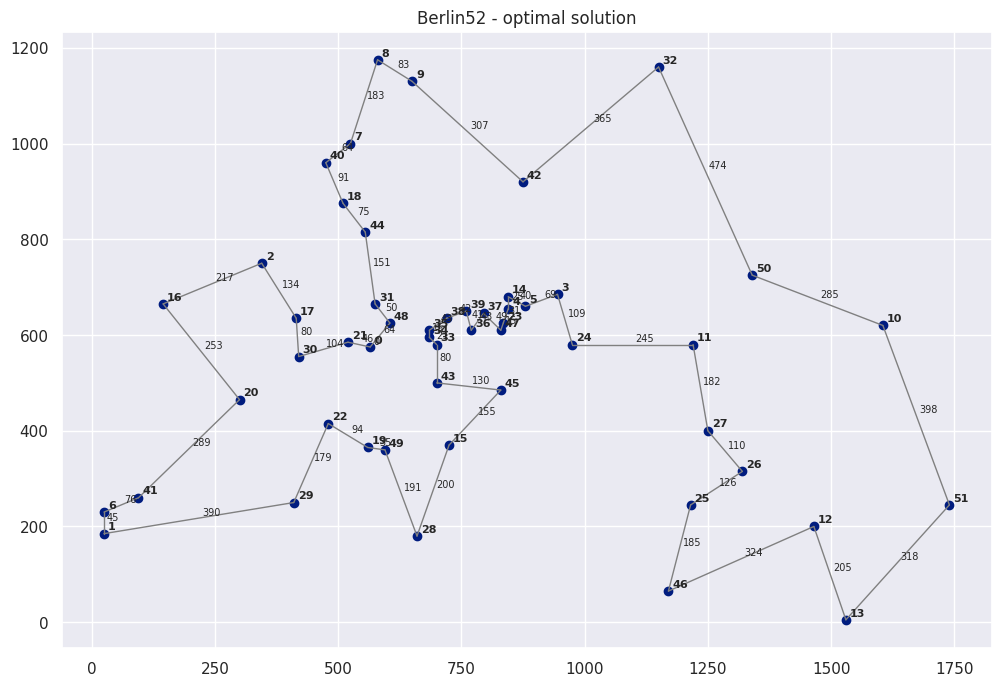

In [32]:
from matplotlib.lines import Line2D


def plot_solution(route, coords, A, title = None):
    n = len(coords)
    plt.figure(figsize=(12,8))
    fig, ax = plt.subplots(figsize=(12,8))

    plt.plot(coords[:, 0], coords[:, 1], 'o')

    for i in range(n):
        plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

    plt.text((coords[0, 0] + coords[route[0], 0])/2 + 6,
            (coords[0, 1] + coords[route[0], 1])/2 + 6,
            '%d' % A[0, route[0]], fontdict={'weight':'normal', 'size':7})
    for i in range(1, len(route)):
        ax.add_line(Line2D(
            [coords[route[i-1], 0], coords[route[i], 0]],
            [coords[route[i-1], 1], coords[route[i], 1]],
            linewidth=1, color='gray'))
        plt.text((coords[route[i-1], 0] + coords[route[i], 0])/2 + 6,
                (coords[route[i-1], 1] + coords[route[i], 1])/2 + 6,
                '%d' % A[route[i-1], route[i]], fontdict={'weight':'normal', 'size':7})
    ax.add_line(Line2D(
        [coords[route[-1], 0], coords[route[0], 0]],
        [coords[route[-1], 1], coords[route[0], 1]],
        linewidth=1, color='gray'))
    plt.text((coords[route[-1], 0] + coords[0, 0])/2 + 6,
            (coords[route[-1], 1] + coords[0, 1])/2 + 6,
            '%d' % A[route[-1], 0], fontdict={'weight':'normal', 'size':7})

    plt.title(title)
    plt.show()

route = [0, 48, 31, 44, 18, 40,  7,  8,  9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24,  3,  5, 14,  4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29,  1,  6, 41, 20, 16,  2, 17, 30, 21]
plot_solution(route, coords, A, 'Berlin52 - optimal solution')


## Objective function

In [5]:
def tsp_objective_function(p):
    s = 0.0
    for i in range(n):
        s += A[p[i-1], p[i]]
    return s

In [6]:
print(tsp_objective_function(route), route)

7544.365901904086 [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21]


## a) PMX implementation

In [7]:
# https://www.rubicite.com/Tutorials/GeneticAlgorithms/CrossoverOperators/PMXCrossoverOperator.aspx/
def PMX(parent1, parent2):
    plength = len(parent1)
    begin, end = np.sort(np.random.choice(np.arange(plength+1), size=2, replace=False))

    def make_offspring(p1, p2):
        offspring = np.zeros(plength, dtype=p1.dtype)

        # Copy swath into offspring
        swath = offspring[begin:end] = p1[begin:end]
        swath = set(swath)

        # Copy residuals from parent2
        for i in np.concatenate([np.arange(0, begin), np.arange(end, plength)]):
            candidate = p2[i]
            while candidate in swath:
                candidate = p2[np.where(p1 == candidate)[0][0]]
            offspring[i] = candidate
        return offspring

    offspring1 = make_offspring(parent1, parent2)
    offspring2 = make_offspring(parent2, parent1)
    return offspring1, offspring2

## b) Method comparison

### Random Sampling

In [8]:
def random_sampling(T = 100000):
    permutations = np.empty((T, n), dtype=np.int64)
    costs = np.zeros(T)
    for i in range(T):
        permutations[i, :] = np.random.permutation(n)
        costs[i] = tsp_objective_function(permutations[i, :])
    return permutations[costs.argmin(), :], costs

p, costs = random_sampling()
print(tsp_objective_function(p), p)

22555.880578524364 [12 10 25 45 14 43 49  5 21 31  0 29  6 35 41 17 15 22 47  9 20 16 33  2
 28 23 11 26 51 13 37 39 34 40 46 24  8  1 30  7 18 50 19 36 38 48 44 32
 42  3  4 27]


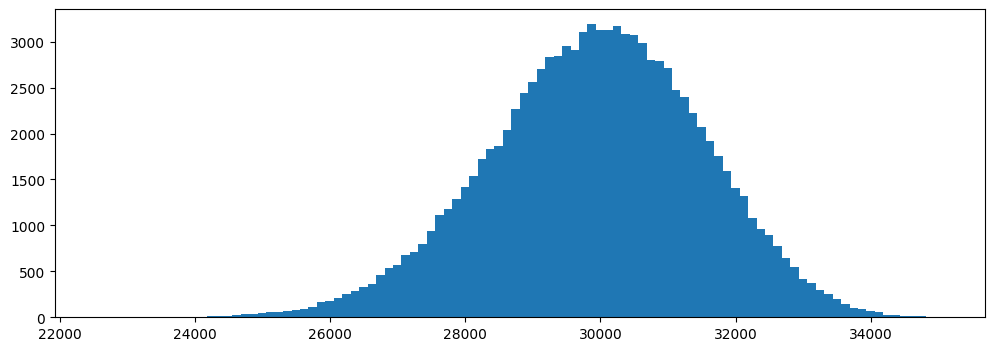

29922.77375604215 1576.3132647032648


In [9]:
plt.figure(figsize=(12,4))
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

### Simulated Annealing

In [10]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [11]:
def simulated_annealing(T = 10000, radius = 1, alpha = 1.0):
    p = np.random.permutation(n)
    p_cost = tsp_objective_function(p)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = tsp_objective_function(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    return p, costs

p, costs = simulated_annealing()
print(costs.min())

10349.971241380994


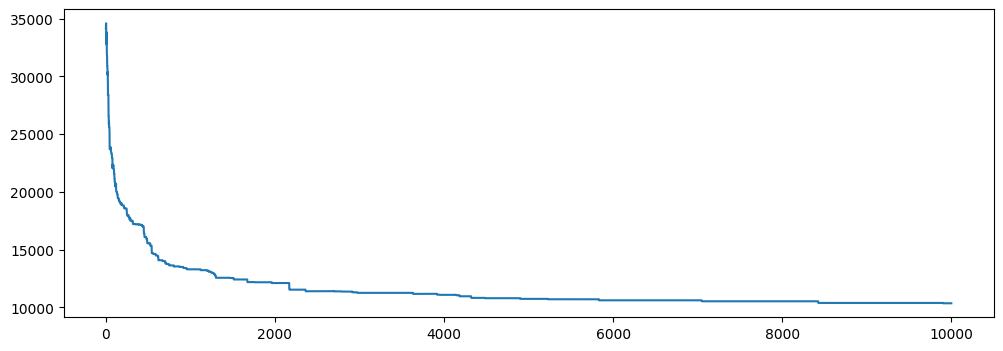

In [12]:
plt.figure(figsize=(12,4))
plt.plot(costs)
plt.show()

### SGA-PMX

In [13]:
from SGA import simple_genetic_algorithm

def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

def default_simple_genetic_algorithm_score():
    return list(simple_genetic_algorithm(n, PMX, reverse_sequence_mutation, tsp_objective_function, verbose = False))[-1][1]

### histograms

In [14]:
from utils import histogram
samples = 300

In [15]:
sga = [default_simple_genetic_algorithm_score() for _ in range(samples)]

In [16]:
_, rs = random_sampling(T = samples)

In [17]:
sa = [min(simulated_annealing()[1]) for _ in range(samples)]

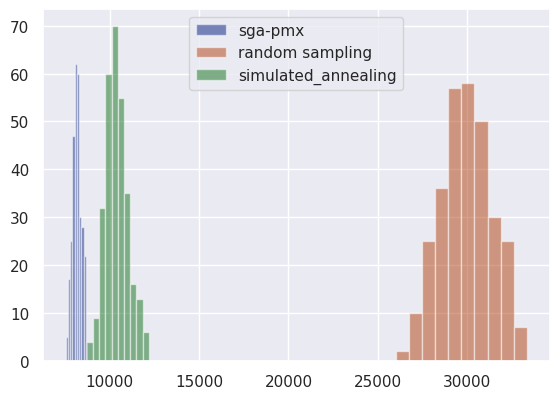

7544.365901904087 25988.431858329564 8733.146360229155


<Figure size 640x480 with 0 Axes>

In [18]:
histogram(
	sga, rs, sa,
	legend = ["sga-pmx", "random sampling", "simulated_annealing"],
	overlap=1
)
print(min(sga), min(rs), min(sa))

## c) Objective function plot

In [19]:
from utils import quickplot

values = [v for c, v in simple_genetic_algorithm(n, PMX, reverse_sequence_mutation, tsp_objective_function, steps = 300)]
print(min(values))

8407.539471290973


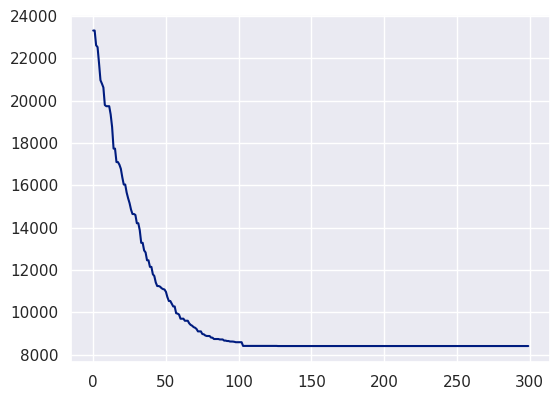

<Figure size 640x480 with 0 Axes>

In [20]:
quickplot(values)

## d) Mutations through transpositions

In [21]:
def transposition_mutation(p):
    q = p.copy()
    i, j = np.random.choice(len(p), 2, False)
    q[i], q[j] = q[j], q[i]
    return q

In [22]:
values = [v for c, v in simple_genetic_algorithm(n, PMX, transposition_mutation, tsp_objective_function, steps = 300)]
print(min(values))

10364.387268125514


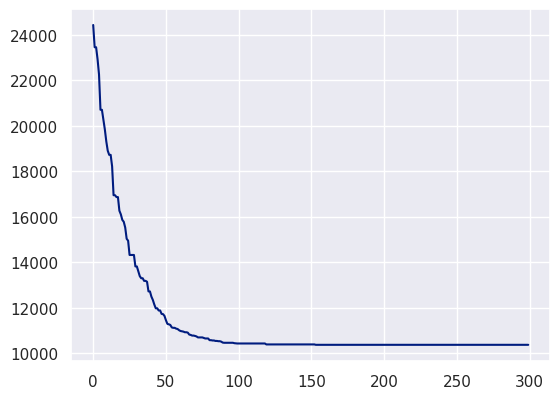

<Figure size 640x480 with 0 Axes>

In [23]:
quickplot(values)

## d) Other problem instances

In [33]:
from downloads import download_data
bayg29 = download_data("bayg29.tsp", 38, 66)
bays29 = download_data("bays29.tsp", 39, 66)
kroA100 = download_data("kroA100.tsp", 8, 105)
kroA150 = download_data("kroA150.tsp", 7, 156)
kroA200 = download_data("kroA200.tsp", 7, 206)

def get_sga_route(chromosome, objf, steps = 1000):
    return list(simple_genetic_algorithm(chromosome, PMX, reverse_sequence_mutation, objf, verbose = False, steps=steps))[-1]

def objf(n, A):
    def tsp_objective_function(p):
        s = 0.0
        for i in range(n):
            s += A[p[i-1], p[i]]
        return s
    return tsp_objective_function

def solve(problem_instance, steps = 1000):
    n, A, coords = load_data(problem_instance)
    route, score = get_sga_route(n, objf(n, A), steps=steps)
    print(route, n, len(coords), len(route))
    plot_solution(route, coords, A, f"Generation {steps} with score of {score}")

[ 9 19  1 20  4 28  2 25  8 11  5 27  0 23 15 26  7 22  6 24 10 21 16 13
 17 14  3 18 12] 29 29 29


<Figure size 1200x800 with 0 Axes>

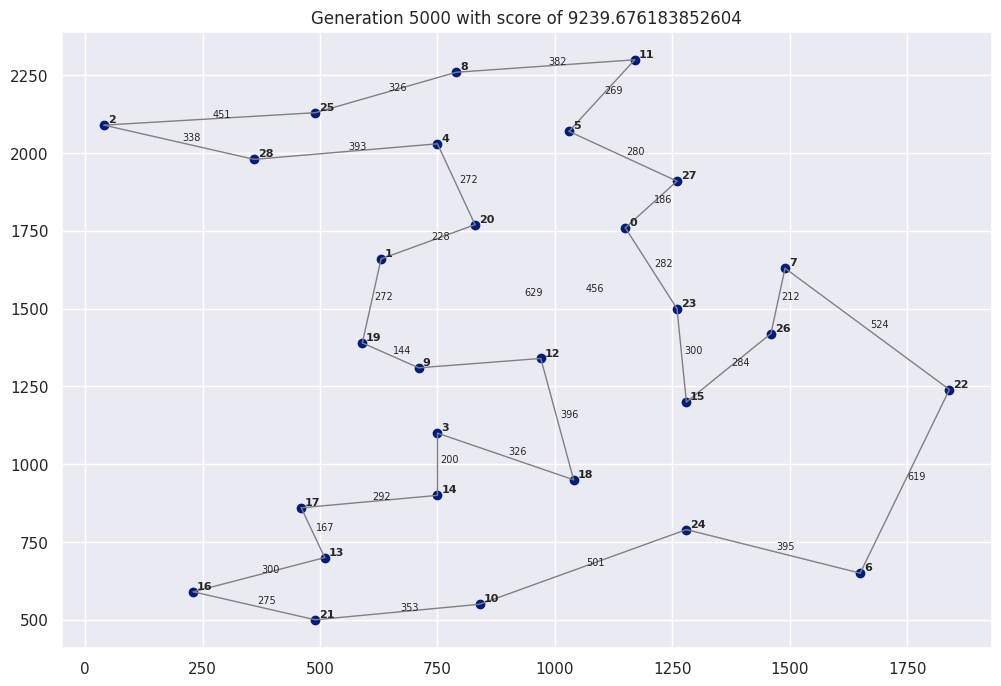

In [34]:
solve(bayg29, steps = 5000)

[ 6 24 18 15 23 12  3 14 10 21 16 13 17  9 19  1 20 28  2 25  4  8 11  5
 27  0  7 26 22] 29 29 29


<Figure size 1200x800 with 0 Axes>

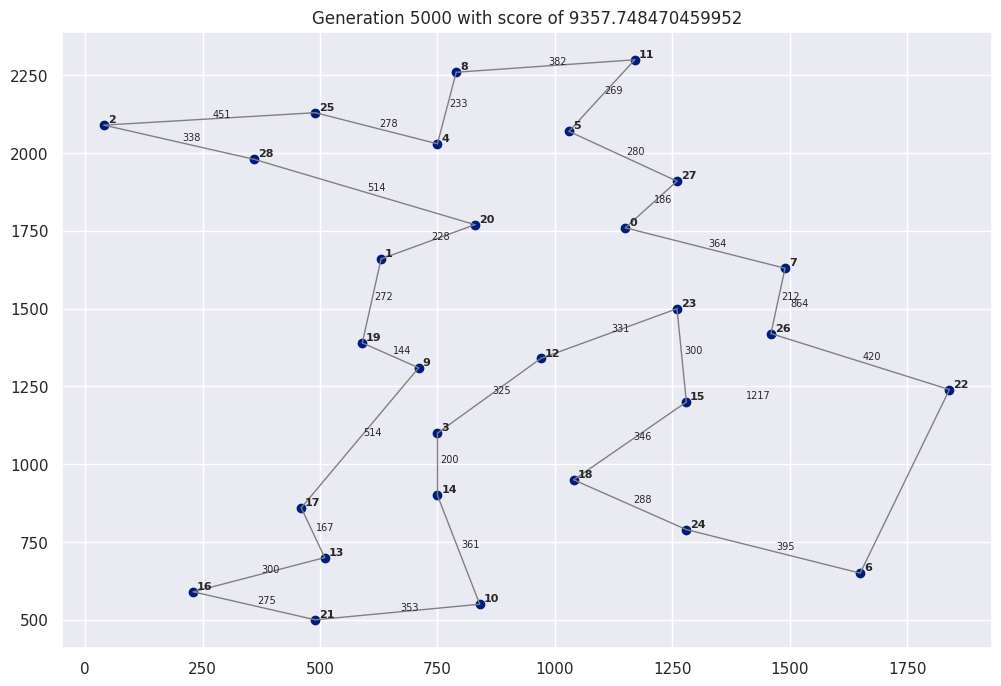

In [35]:
solve(bays29, steps = 5000)

[65 26 91 61  4 47 88 77 51 17 73 90  6 40 87 29 78 54 95  2 63 24 64 68
 20 14 86 92 16 22 36 97 34 82  8 70 19 72 57 15 13  9 30 45 89 43 96 21
 58 60 33 84 25 18 10 53 81 32 27 44 41  1 12 69 39 98 46 50 76  3 35 31
 74 11 93 80 48 42  0 52 38 62 67 71 66 83 37 94 28  7  5 55 75 85 49 23
 79 59 56] 99 99 99


<Figure size 1200x800 with 0 Axes>

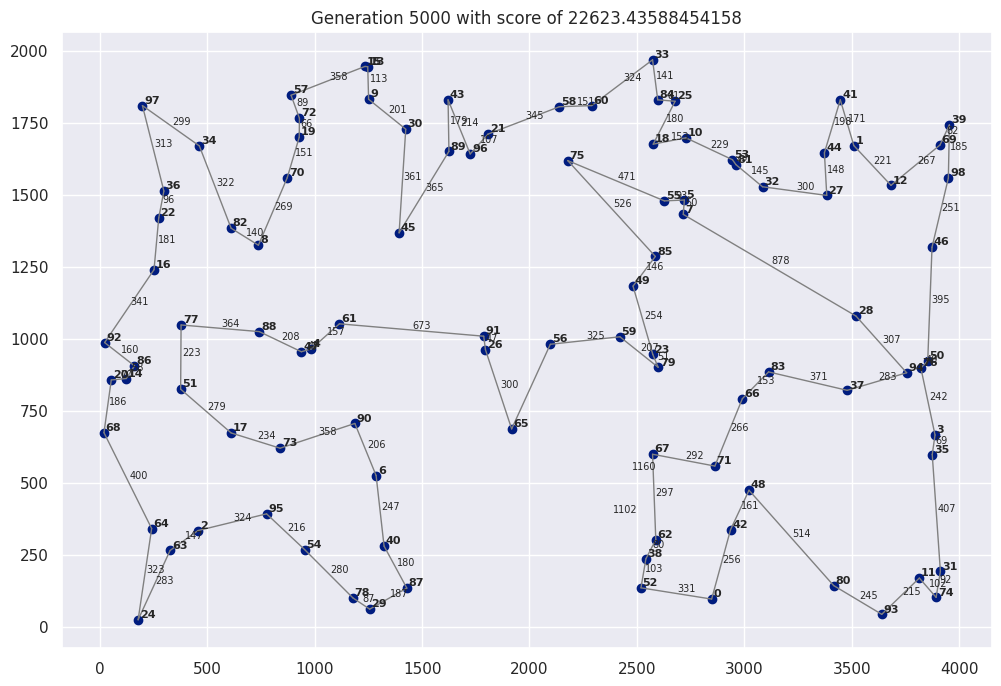

In [36]:
solve(kroA100, steps = 5000)

[ 63  39  53 137 132  88  30  79 121  41   7  91 138  55 142 118 117 123
  25 128  65  64   3  96  74  48   5 112   9  83  89 105  18  52 133  87
  15  69  21  93 136  78  17  23  37 103 110 101  98  35 126  58 140  73
  20  71  10  16  14  44  97  90 108  31  46  62   0 129 147 141 104  66
 107  57  27  92 130  22 109  76  59  61 149  34  85  26  19  11 148  54
  82  33 119 114 122  42 127 135   2  45  28 131  13  70  40  99  47 111
 106  29 120 100  38  95  77  51   4  36 146  12 102 145  32  75  94 125
  81 115  67  84 134 139 116   8   6  56 144  86 124  50  60  24  80  68
  72  49  43 113   1 143] 150 150 150


<Figure size 1200x800 with 0 Axes>

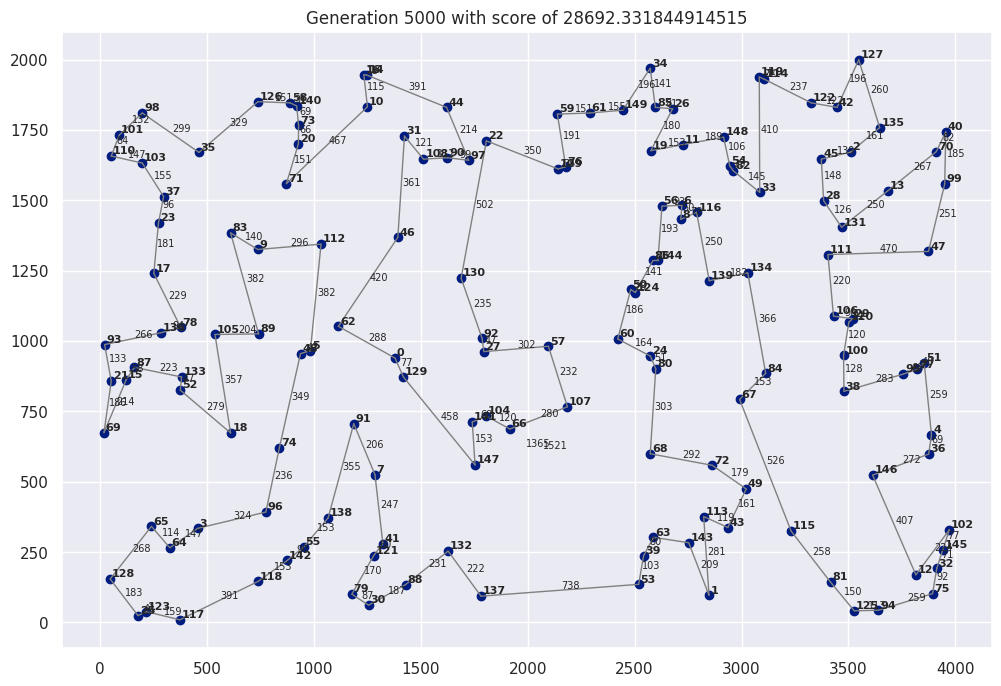

In [37]:
solve(kroA150, steps = 5000)

[ 46 119 111 126 185 134  41  54  19  63 161  66 176 159  78  12  14 122
 197  26 190 144  84   0  52 114 116 110 131  39 146  11  48  45 171 120
 173 158  23  31 135  60  25 198   6  81  77   8 137 123 117  15  62  43
 187 115  50 193 121 169  51  10  83  47 165  86 125  95 164 103  96  80
  44 196 174   9  91  98  18 118  65 152 178  36 183  28 109  17 189 148
 105  92 162   3 100  59 107 191  13  35  56  73  99  32 155 179 130 188
 141  68   2  72  58  40 166 127 192 157  76 160  79  64 150 124 180   1
  34  67  29 168 172  22 163  88 139  20 153 101  75  69 143 149  90  94
  93 181 194 112 175 132 136  42 104   4 177 151  55  37 129  70 195  85
 138  71  82  61  49 184 167  53  74  21 133 128  38  27 147  87 199 170
 140  57  97 113 102 145 142  89  33  24  16   7 182 154 106 108   5 186
 156  30] 200 200 200


<Figure size 1200x800 with 0 Axes>

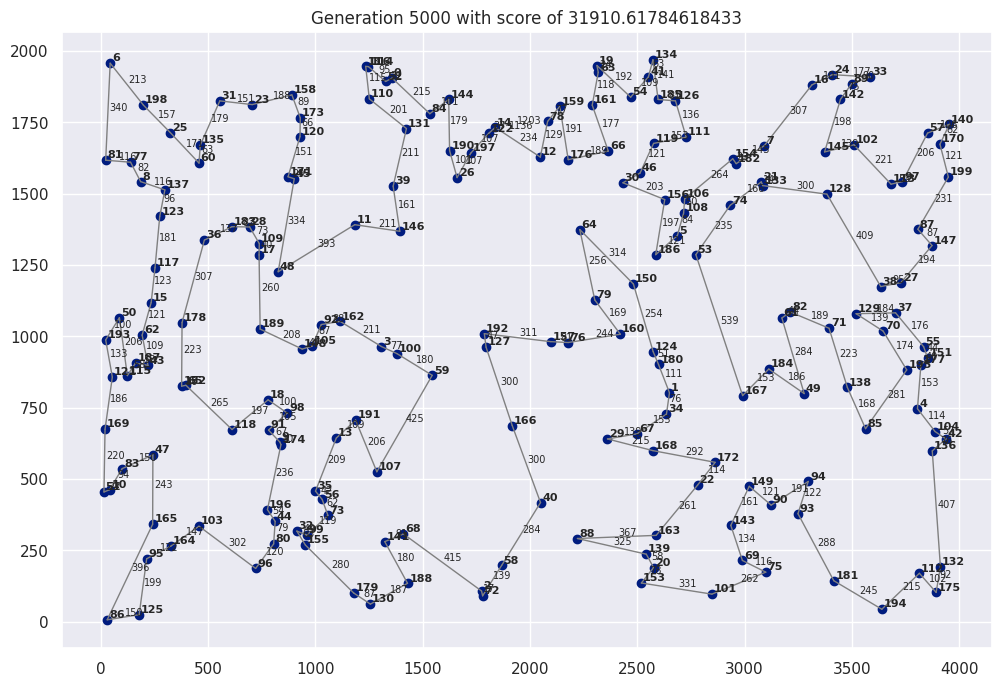

In [38]:
solve(kroA200, steps = 5000)